# Collecting Main Points from Tweets

From the previous section we built a comfortable understanding of collecting tweets from a specific hashtag. Utilizing tweepy and it's API any number of tweets could be collected. Nearly 50% of these tweets were original yielding a huge amount of different points and unique tweets that are relevant to the searched hashtag. In this section, these tweets will be filtered to and grouped to see if we can gather key points about certain events. Instead of selecting a specific tweet such as #Trump, let's use tweepy's API to find what's trending so this step is automated.

In [13]:
import keys
import tweepy
from pprint import pprint
consumer_key = keys.CONSUMER_KEY
consumer_secret = keys.CONSUMER_SECRET
access_token = keys.ACCESS_TOKEN
access_token_secret = keys.ACCESS_TOKEN_SECRET
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

From the tweepy documentation we can use api.trends_place which brings the trending tweets for a particular location. By passing 1 to this function it returns the trending tweets across the world.

>**API.trends_place(id[, exclude])**

>Returns the top 10 trending topics for a specific WOEID, if trending information is available for it.

>The response is an array of “trend” objects that encode the name of the trending topic, the query parameter that can be used to search for the topic on Twitter Search, and the Twitter Search URL.

>This information is cached for 5 minutes. Requesting more frequently than that will not return any more data, and will count against your rate limit usage.

>Parameters:	
>id – The Yahoo! Where On Earth ID of the location to return trending information for. Global information is available by using 1 as the WOEID.
>exclude – Setting this equal to hashtags will remove all hashtags from the trends list.

>Return type: JSON object

In [21]:
from pprint import pprint
pprint(api.trends_place(1), depth=2)

[{'as_of': '2017-04-06T07:47:44Z',
  'created_at': '2017-04-06T07:47:12Z',
  'locations': [...],
  'trends': [...]}]


From the trending tweets we can see a dictionary is passed inside of a list object. Inside this dictionary various metadata about the request is included, as well as a key called 'trends' which contains a list of different trending tweets. #aprilfoolsdaycan be seen to have an enormous tweet volume at the moment (today is April 1st), however, many tweets are not in English. To try to narrow down the trending tweets to more relevant stories, let's see what's happening in Toronto! Looking up Toronto's WOEID shows that it is 4118. Let's pass that to the request instead of 1.

In [19]:
toronto_trends = api.trends_place(4118)
toronto_trends = toronto_trends[0]
from pprint import pprint
pprint(api.trends_place(1), depth=2)

[{'as_of': '2017-04-06T07:46:34Z',
  'created_at': '2017-04-06T07:42:09Z',
  'locations': [...],
  'trends': [...]}]


Looks like all the trending tweets are in English. Interestingly, these are not also specific to hashtags, therefore, Twitter may be able to find trending topics already for us which do not revolove around hashtags specifically. Let's see the properties of these tweets.

In [32]:
print("The API returned {} trending tweets when looking at Toronto.\n".format(len(toronto_trends['trends'])))
sorted_trends = sorted(toronto_trends['trends'], key=lambda x: x['tweet_volume'] if x['tweet_volume'] else 0)
print("Sorted by volume, the top 10 are as follows:\n")
for i in range(10):
    print(i+1, sorted_trends[i]['name'])

The API returned 46 trending tweets when looking at Toronto.

Sorted by volume, the top 10 are as follows:

1 #TFCLive
2 #15andFairness
3 Sunshine List
4 Game 5
5 DeMar DeRozan
6 Pacers
7 Toronto FC
8 #JUNOS
9 #IllNeverBeTooOldFor
10 #BlueJaysMTL


As seen from the tweets, many relevant tweets specific to Toronto can be seen. This includes the Toronto football club (TFC), the minimum wage (15 and fairness) as well as the Sunshine List (annual report on any Canadian public worker earning $100,000+). Let's grab the top tweets on TFCLive, dump them in a pickle and create a word cloud following section 3.1.2.

In [3]:
import pickle
full_tfc_statuses = [status for status in tweepy.Cursor(api.search, '#TFCLive', tweet_mode='extended', languages=["en"]).items(1000)]
pickle.dump(full_tfc_statuses, open('pickle_dumps/full_tfc_statuses.p', 'wb'))
print("Saved!")

Saved!


In [6]:
%%capture
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import pickle, re

# Get all tweets
full_tfc_statuses = pickle.load(open('pickle_dumps/full_tfc_statuses.p', 'rb'))
# Convert retweets to original tweet
original_full_tweets = [t.retweeted_status  if 'retweeted_status' in dir(t) else t
                           for t in full_tfc_statuses]
pickle.dump(original_full_tweets, open('pickle_dumps/original_full_tfc_tweets.p', 'wb'))

# Clean tweets
used_tweets = set()
full_tweet_text = []
for tweet in original_full_tweets:
    if tweet.id not in used_tweets:
        used_tweets.add(tweet.id)
        # Obtain text and remove urls
        cleaned_tweet = re.sub("http\S+", "", tweet.full_text)
        full_tweet_text.append(cleaned_tweet)
        
cleaner_text_dump = ' '.join(full_tweet_text)
pickle.dump(cleaner_text_dump, open('pickle_dumps/tfc_tweets_text_dump.p', 'wb'))

# We'll make the words into a sillhoute of a soccer player
# Found at https://www.pinterest.com/pin/469992911093328088/
football_mask = np.array(Image.open("images/football_mask.png"))

stopwords = set(STOPWORDS)
stopwords.add('TFCLive')
stopwords.add('amp')
stopwords.add('rt')

wc = WordCloud(background_color="white", max_words=2000, mask=football_mask,
               stopwords=stopwords)

# generate word cloud
wc.generate(cleaner_text_dump)

# store to file
wc.to_file("images/football_word_cloud.png")

The resulting wordcloud from repeating these results are as below.
<img src="images/football_word_cloud.png" alt="TFC Wordcloud" width=400>
TORvSKC can be seen to be the top trending word (likely a hashtag), so let's filter tweets containing this text to filter down our tweets to relevant information. We'll first find TORvSKC via the natural language processing tool kit (NLTK) to find the most common words numerically so that this step can be automated in the future. Let's install NLTK.
```
$ pip install nltk
```
Now we should be able to get a nice cumulative distribution of the words following the [NLTK tutorial](http://www.nltk.org/book/ch01.html).

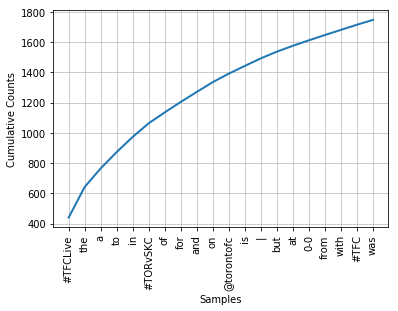

In [14]:
# Get the text dump
import pickle
tfc_tweets_text_dump = pickle.load(open('pickle_dumps/tfc_tweets_text_dump.p', 'rb'))

# Create the distribution
from nltk import FreqDist
word_distribution = FreqDist(tfc_tweets_text_dump.split())
word_distribution.most_common()

# Plot
word_distribution.plot(20, cumulative=True)

Looking at the word distribution the most common words can be seen to include a lot of words like "the", "a" and "to". Let's remove the stopwords.

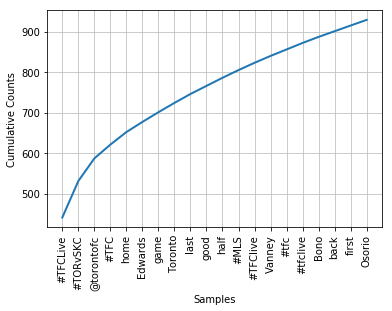

In [29]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stopword_free_text_dump =  [w for w in tfc_tweets_text_dump.split() 
                            if w.lower() not in stopwords 
                            and len(w) > 3]
stopword_free_distribution = FreqDist(stopword_free_text_dump)

# Plot
stopword_free_distribution.plot(20, cumulative=True)

Now that we have our top trending words, let's try to group different statuses based on whether they contain each word or not.